In [8]:
import json
import pandas as pd
import csv
import seaborn as sns
import matplotlib.pyplot as plt
import wikipedia
import numpy as np
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from sklearn.feature_selection import RFE, RFECV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import re
from pandas.plotting import register_matplotlib_converters
from sklearn.utils import resample
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.feature_selection import RFE

In [26]:
vids = pd.read_csv('files/df_sans_zero_sentiments.csv')
#filter out outliers with not many comments (not enough comments for sentiment analysis to be robust)
for col in vids.columns[3:]:
    if str(vids[col].dtype) != 'object':
        vids = vids[(np.abs(stats.zscore(vids[col])) < 3)]
vids = vids[vids['commentCount'] > 100]
vids = vids.drop(['Unnamed: 0'],axis=1)
vids.index = pd.to_datetime(vids.date)

In [27]:
vids.columns

Index(['date', 'title', 'class', 'viewCount', 'commentCount', 'likeCount',
       'dislikeCount', 'ratio', 'magMean', 'magStd', 'magMin', 'magLq',
       'magMedian', 'magUq', 'magMax', 'sentMean', 'sentStd', 'sentMin',
       'sentLq', 'sentMedian', 'sentUq', 'sentMax'],
      dtype='object')

In [28]:
#6 equally distributed categories of likes/dislikes ratio
bin_labels = [0, 1, 2, 3, 4, 5]
vids['ratio_bins'] = pd.qcut(vids['ratio'], q=6, labels = bin_labels)

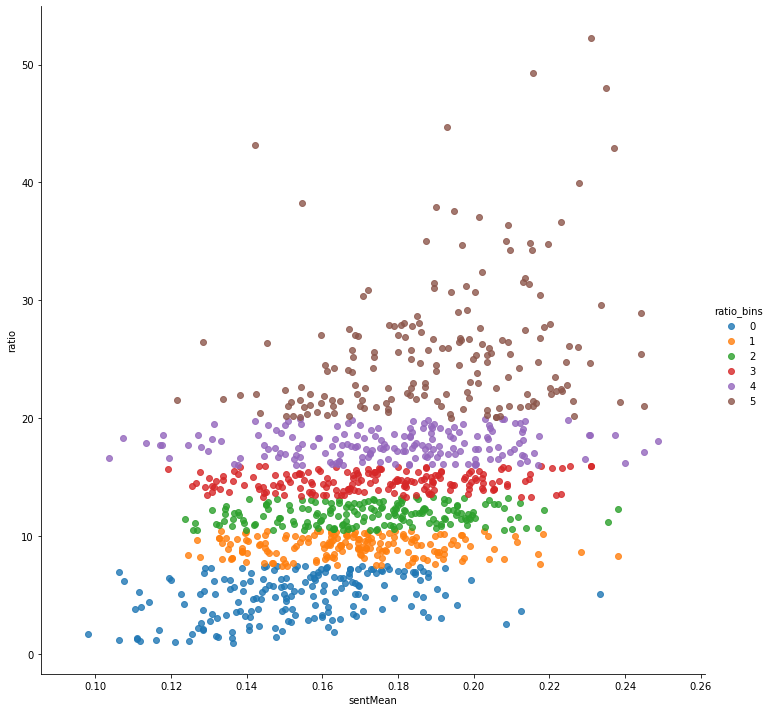

In [11]:
#basic visualisation of ratio between sentiment and ratio
_p = sns.lmplot("sentMean", "ratio", data=vids, fit_reg=False, hue='ratio_bins', height=10)

## to do: visualisation and exploration of our data

In [31]:
likes_and_dislikes = vids[['likeCount','dislikeCount']]

In [34]:
vids.columns

Index(['date', 'title', 'class', 'viewCount', 'commentCount', 'likeCount',
       'dislikeCount', 'ratio', 'magMean', 'magStd', 'magMin', 'magLq',
       'magMedian', 'magUq', 'magMax', 'sentMean', 'sentStd', 'sentMin',
       'sentLq', 'sentMedian', 'sentUq', 'sentMax', 'ratio_bins'],
      dtype='object')

In [ ]:
cols = ['viewCount','commentCount','likeCount','dislikeCount','ratio','magMean','sentMean']
titleList = ['views','comment count','likes and dislikes','ratio','magnitude mean','sentiment mean']

fig,axes = plt.subplots(len(cols), 1, sharex=False, sharey=False,figsize = (15,40))
plt.tight_layout()
fig.suptitle('key variables over time', size='40',y=1.05)
for i, ax in enumerate(axes.flat):
    sns.lineplot(data=vids,x=vids.index,y=cols[i],ax=ax)

Text(0.5, 1, 'likes and dislikes over time\n')

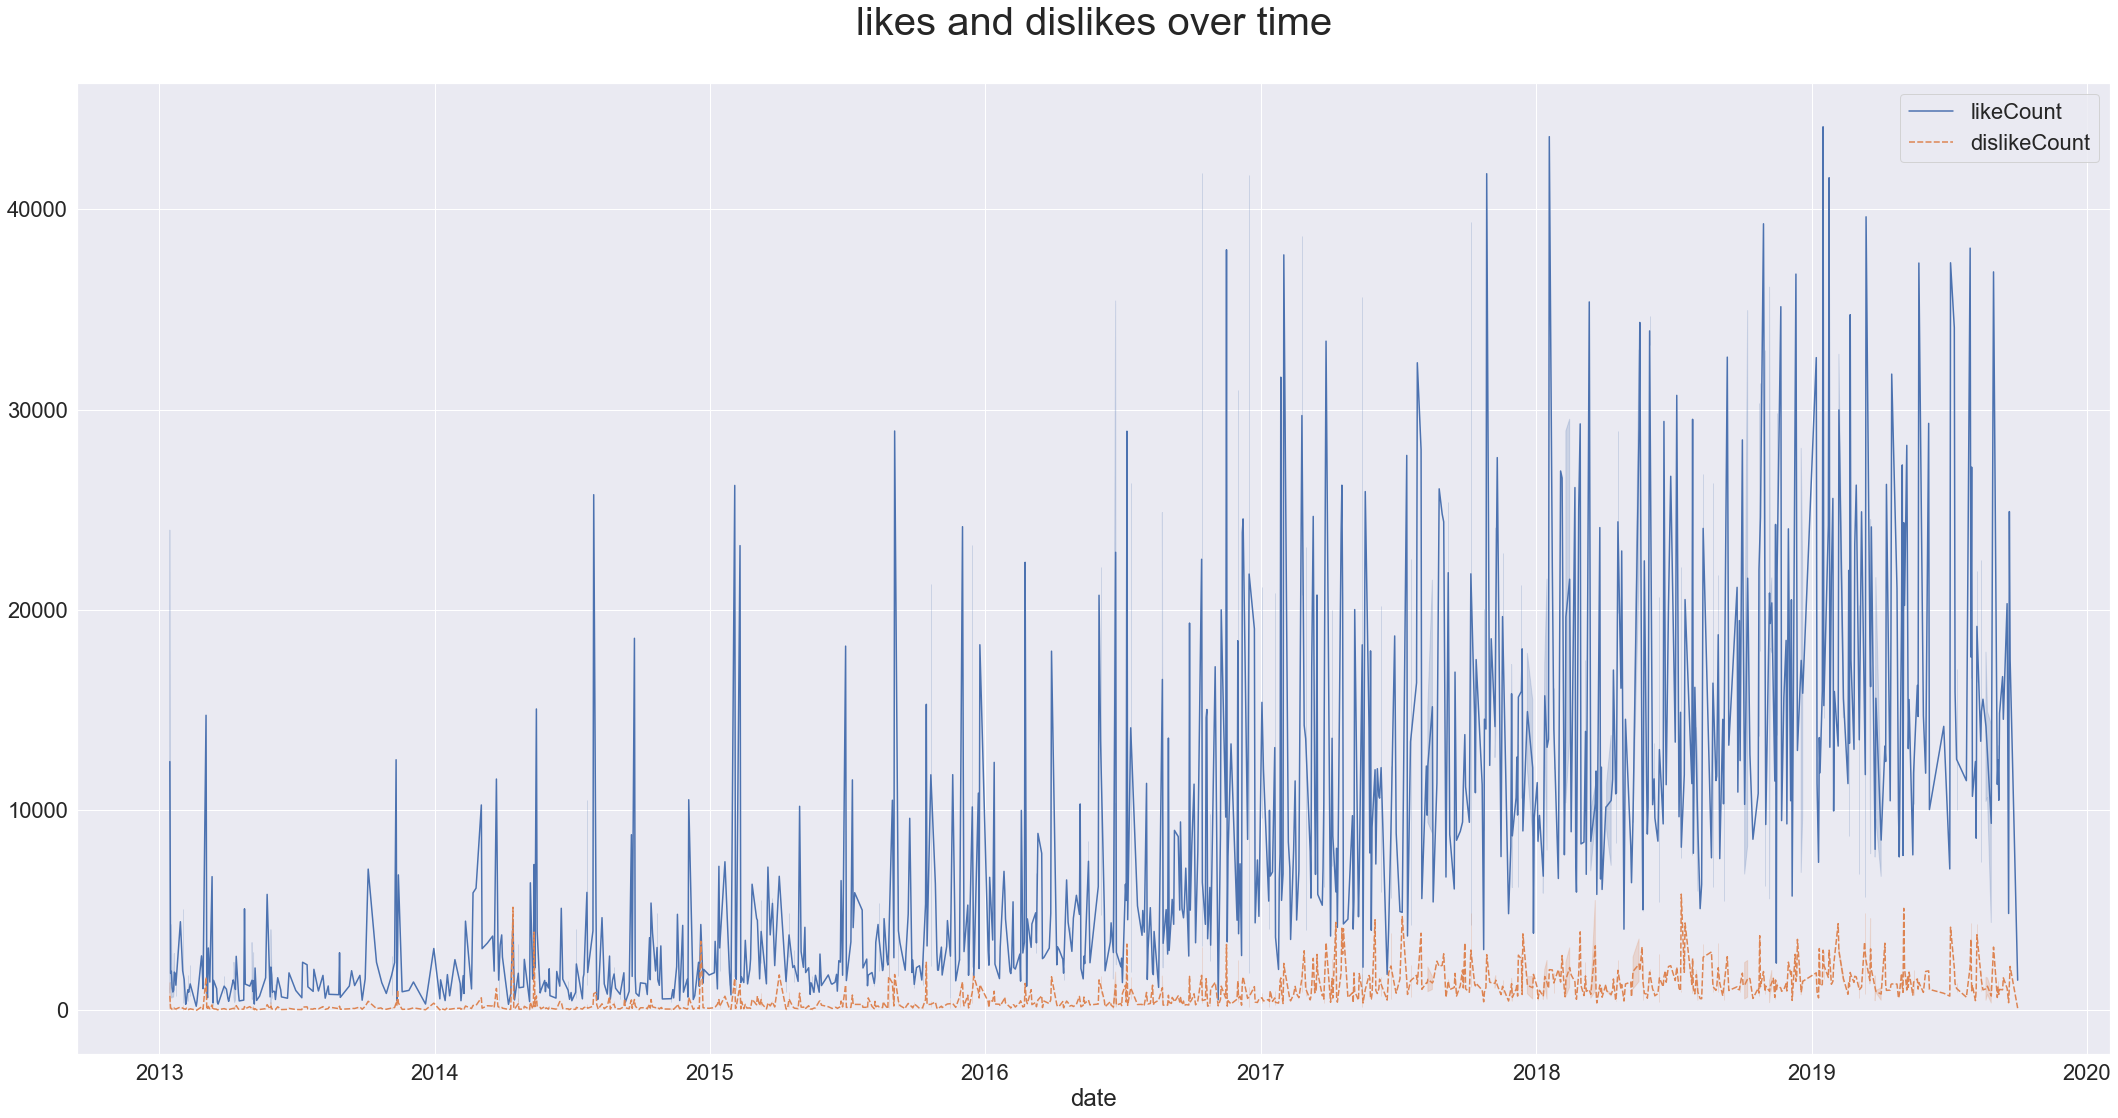

In [33]:
 plt.figure(figsize=(30,15))
sns.set(font_scale=2)
sns.lineplot(data=likes_and_dislikes)
plt.tight_layout()
plt.title('likes and dislikes over time\n', size='40')